In [2]:
from torchdiffeq import odeint_adjoint as odeint
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch 

In [3]:
#Instantiate functions to compute activation and repression
def activation(x, k, theta, n):
    return (k*(x/theta)**n)/(1+(x/theta)**n)

def repression(x, k, theta, n):
    return k/(1+(x/theta)**n)

def nonlinearity(x, kc, km):
    return (kc*x)/(km+x)

In [4]:
def dual_control(t, y):
    """ we create rhs equations for the problem"""
    ydot = torch.zeros(6)
    ydot[0] = Vin - lam*y[0] - e0*nonlinearity(y[0], kc, km) - lam*y[1]
    ydot[1] = y[2]*nonlinearity(y[0], kc, km) - y[3]*nonlinearity(y[1], kc, km) - lam*y[1]
    ydot[2] = repression(y[1], k1, theta1, n1) - lam*y[2]
    ydot[3] = activation(y[1], k2, theta2, n2) - lam*y[3]
    ydot[4] = (Vin -  y[3]*nonlinearity(y[1], kc, km))**2
    ydot[5] = repression(y[1], k1, theta1, n1) + activation(y[1], k2, theta2, n2)
    return ydot

In [5]:
#Times
t = torch.from_numpy(np.linspace(1,5e4,200))
#Constants
Vin = 1
e0 = 0.0467 
lam = 1.93E-4 #1/s
#Assume equal kinetics for all three enzymes
kc = 12 #1/s
km = 10 
#Initial conditions
y0 = torch.from_numpy(np.array([2290., 0., 0., 0., 0., 0.]))
labels = ['theta', 'k1', 'k2', 'x0', 'x1', 'e1', 'e2', 'j1', 'j2', 'v2']

n1 = 2
n2 = 2
num_points = 10
thetas = [1]
ks = np.linspace(1E-7, 0.001, num_points)

In [6]:
ss_data = pd.DataFrame(columns=labels)
for theta1 in thetas:
    theta2 = theta1
    for k1 in ks:
        for k2 in ks:
            print('Solving equation with parameters: ', theta1, k1, k2)
            solution = odeint(dual_control, y0, t, adjoint_params=())
            x0, x1, e1, e2, j1, j2 = solution[-1]
            v2 = e2*nonlinearity(x1, kc, km)
            row = [theta1, k1, k2, x0, x1, e1, e2, j1, j2, v2]
            ss_data.loc[len(ss_data)] = row

Solving equation with parameters:  1 1e-07 1e-07
Solving equation with parameters:  1 1e-07 0.00011119999999999999
Solving equation with parameters:  1 1e-07 0.00022229999999999998
Solving equation with parameters:  1 1e-07 0.00033339999999999997
Solving equation with parameters:  1 1e-07 0.00044449999999999996
Solving equation with parameters:  1 1e-07 0.0005556
Solving equation with parameters:  1 1e-07 0.0006666999999999999
Solving equation with parameters:  1 1e-07 0.0007777999999999998
Solving equation with parameters:  1 1e-07 0.0008888999999999999
Solving equation with parameters:  1 1e-07 0.001
Solving equation with parameters:  1 0.00011119999999999999 1e-07
Solving equation with parameters:  1 0.00011119999999999999 0.00011119999999999999
Solving equation with parameters:  1 0.00011119999999999999 0.00022229999999999998
Solving equation with parameters:  1 0.00011119999999999999 0.00033339999999999997
Solving equation with parameters:  1 0.00011119999999999999 0.0004444999999

In [12]:
ss_data.to_csv('torchode_results.csv')

Text(0, 0.5, 'k2')

<Figure size 432x288 with 0 Axes>

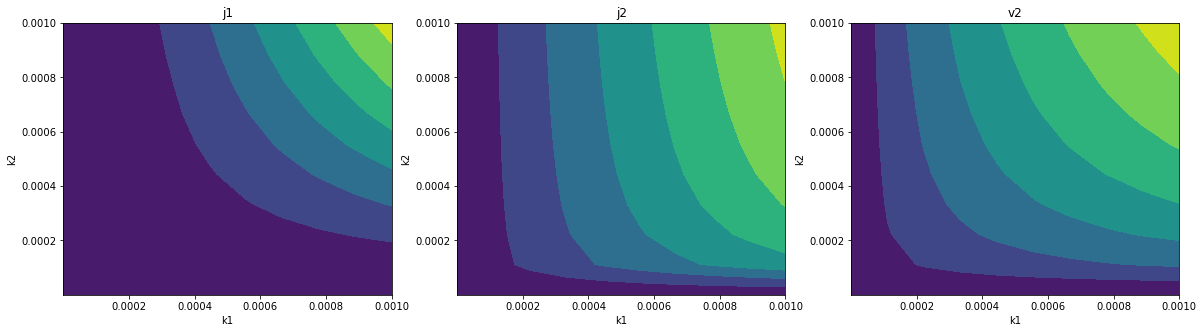

In [28]:
 
fig = plt.figure()
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

endpoint = 'j1'
X = ss_data.k1.unique()
Y = ss_data.k2.unique()
Z = np.array(ss_data[endpoint]).reshape((len(X), len(Y)))
   

axs[0].contourf(X,Y,Z)
axs[0].set_title(f'{endpoint}')
axs[0].set_xlabel('k1')
axs[0].set_ylabel('k2')

endpoint = 'j2'
X = ss_data.k1.unique()
Y = ss_data.k2.unique()
Z = np.array(ss_data[endpoint]).reshape((len(X), len(Y)))
   
axs[1].contourf(X,Y,Z)
axs[1].set_title(f'{endpoint}')
axs[1].set_xlabel('k1')
axs[1].set_ylabel('k2')

endpoint = 'v2'
X = ss_data.k1.unique()
Y = ss_data.k2.unique()
Z = np.array(ss_data[endpoint]).reshape((len(X), len(Y)))
   
axs[2].contourf(X,Y,Z)
axs[2].set_title(f'{endpoint}')
axs[2].set_xlabel('k1')
axs[2].set_ylabel('k2')